Using device: cuda
Train: 560 | Val: 70
Train batches: 70 | Val batches: 9
VAE created. Parameters: 18371523


Epoch 20/20: 100%|██████████| 70/70 [00:13<00:00,  5.06it/s]


Epoch 20/20 | Train loss: 319771.2188 | Val loss: 290641.6840
Best VAE saved (val loss: 290641.6840)


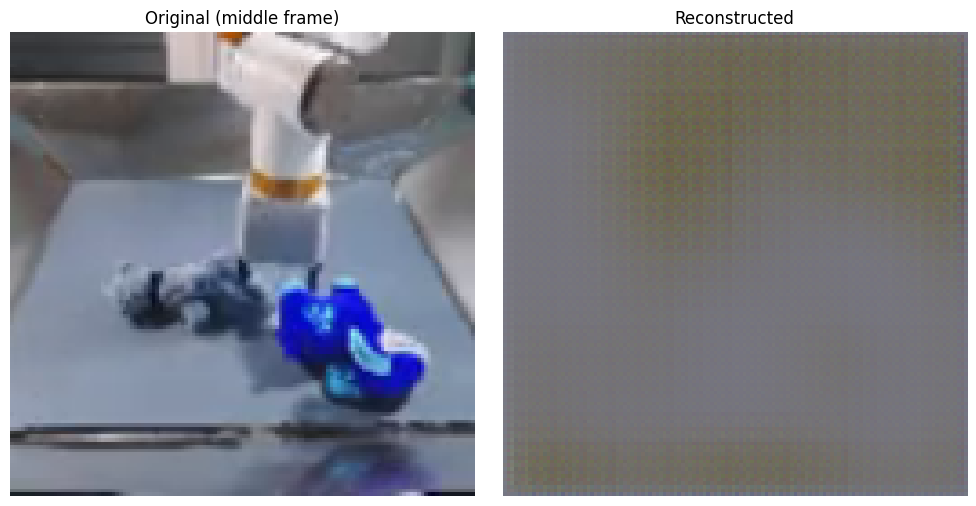

Sample reconstruction MSE: 0.032378
VAE pretraining finished!
Best checkpoint: E:\NVIDIA_PROJECTS\Neural-World-Model-for-Embodied-AI-Robotics\checkpoints\vae_pretrained.pth


In [8]:
# 03_vae_pretraining.ipynb
# =======================================
# VAE Pretraining on RoboNet Frames
# Goal: Learn good latent representations of frames

# ────────────────────────────────────────────────
# 1. Imports & Configuration
# ────────────────────────────────────────────────

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Import your dataset
from models.data_loader import RoboNetDataset

# Paths
PROJECT_ROOT = r"E:\NVIDIA_PROJECTS\Neural-World-Model-for-Embodied-AI-Robotics"
DATA_ROOT = os.path.join(PROJECT_ROOT, "data", "raw", "robonet", "hdf5")
SPLITS_PATH = os.path.join(PROJECT_ROOT, "data", "splits.json")
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 8        # increased — VAE is lighter than full sequence
NUM_WORKERS = 0
EPOCHS = 20
LR = 1e-3
LATENT_DIM = 128      # size of latent vector per frame

# ────────────────────────────────────────────────
# 2. Load splits
# ────────────────────────────────────────────────

with open(SPLITS_PATH, "r") as f:
    splits = json.load(f)

train_files = splits["train"]
val_files   = splits["val"]

print(f"Train: {len(train_files)} | Val: {len(val_files)}")

# ────────────────────────────────────────────────
# 3. Datasets & Loaders (frame-only for VAE)
# ────────────────────────────────────────────────

class FrameOnlyDataset(RoboNetDataset):
    """Wrapper to return only frames for VAE pretraining"""
    def __getitem__(self, idx):
        item = super().__getitem__(idx)
        return item['frames']  # (seq_len, C, H, W)

train_dataset = FrameOnlyDataset(train_files, DATA_ROOT)
val_dataset   = FrameOnlyDataset(val_files,   DATA_ROOT)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

# ────────────────────────────────────────────────
# 4. Simple Convolutional VAE
# ────────────────────────────────────────────────

class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 128→64
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 64→32
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),# 32→16
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),# 16→8
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 8→16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 16→32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # 32→64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),    # 64→128
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


model = VAE().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


print("VAE created. Parameters:", sum(p.numel() for p in model.parameters()))

# ────────────────────────────────────────────────
# 5. Training Loop
# ────────────────────────────────────────────────

best_val_loss = float('inf')
checkpoint_path = os.path.join(CHECKPOINT_DIR, "vae_pretrained.pth")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    num_batches = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x = batch.to(DEVICE)  # (B, seq_len, C, H, W)
        # Flatten sequence for VAE (each frame independent)
        x_flat = x.view(-1, 3, 128, 128)  # (B*seq_len, C, H, W)

        recon, mu, logvar = model(x_flat)
    loss = vae_loss(recon, x_flat, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    num_batches += 1

avg_train_loss = train_loss / num_batches

# Validation
model.eval()
val_loss = 0.0
with torch.no_grad():
    for batch in val_loader:
        x = batch.to(DEVICE)
        x_flat = x.view(-1, 3, 128, 128)
        recon, mu, logvar = model(x_flat)
        val_loss += vae_loss(recon, x_flat, mu, logvar).item()

avg_val_loss = val_loss / len(val_loader)

print(f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train loss: {avg_train_loss:.4f} | Val loss: {avg_val_loss:.4f}")

if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Best VAE saved (val loss: {best_val_loss:.4f})")

# ────────────────────────────────────────────────
# 6. Visualize Reconstructions
# ────────────────────────────────────────────────
SEQ_LEN = 15
model.eval()
with torch.no_grad():
    batch = next(iter(val_loader))
    x = batch.to(DEVICE)  # (B, seq_len, C, H, W)

    x_flat = x.view(-1, 3, 128, 128)
    recon, mu, logvar = model(x_flat)

    # Pick middle frame from first batch item
    mid_idx = SEQ_LEN // 2
    orig = x[0, mid_idx].cpu().permute(1, 2, 0).numpy()
    rec  = recon[mid_idx].cpu().permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(orig)
    axes[0].set_title("Original (middle frame)")
    axes[1].imshow(rec)
    axes[1].set_title("Reconstructed")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Optional: print reconstruction MSE for this sample
    mse = nn.functional.mse_loss(torch.from_numpy(rec).to(DEVICE), torch.from_numpy(orig).to(DEVICE))
    print(f"Sample reconstruction MSE: {mse.item():.6f}")

print("VAE pretraining finished!")
print(f"Best checkpoint: {checkpoint_path}")